<img src="images/housing_market.jpg_fit=scale" width=400 height=400 />

# King County, WA Housing Sales Analysis

# Overview
---

Our team was hired by a hot-shot real estate agency to create a model which predicts the prices of houses in the King County area based on differnt features. These features include: city/town/neighborhood location, square footage, number of bedrooms, whether it's on the water, how good of a view it has, 

To acheive our goal, we will use multiple linear regression models to analyse housing sales in King County, WA  using housing data gathered within the county from 2014 and 2015. 

For this analysis, we have used regression models such as, Ordinary Least Squared, Train-Test Split, and K-Fold Cross Validation models to create an efficient predictive model. 

Our analysis shows that based on the R^2 scores, our regression model's accuracy is 

# Business Understanding
---
Our stakeholder wants to be able to predict the price of a house based on certain features provided by their customers. 

Our project will answer the following questions:
* With what accuracy could we predict the prices of houses based on these features?
* What specific housing features will provide us with the most accurate model? 

# Data Understanding
---
The data used for this project was sourced from a dataset called ‘King County House Sales’ and contains information regarding housing sales statistics in King County, WA.

##### The dataset contains the following columns:

* ```id```: A unique sale id relating to a house sale
* ```date```: Date of house sale
* ```price```: The price which the house sold for
* ```bedrooms```: How many bedrooms the house has
* ```bathrooms```: How many bathrooms the house has
* ```sqft_living```: How much square footage the house has
* ```sqft_lot```: How much square footage the lot has
* ```floors```: How many floors the house has
* ```waterfront```: Whether the house is on the waterfront. Originally contained ‘YES’ or ‘NO’, converted to 0 or 1 for comparative purposes
* ```view```: Whether the house has a view and whether it’s fair, average, good, or excellent. Converted to numberical (0-4) for comparative purposes
* ```condition```: overall condition of the house: Poor, Fair, Average, Good, Very Good
* ```grade```: Numerical grading for house
* ```sqft_above```: How much of the houses square footage is above ground
* ```sqft_basement```: How much of the square footage is in the basement
* ```yr_built```: Year the house was built
* ```yr_renovated```: Year the house was renovated, if applicable
* ```zipcode```: House zipcode
* ```lat```: House’s latitude coordinate
* ```long```: House’s longitude coordinate
* ```sqft_living15```: Average size of living space for the closest 15 houses
* ```sqft_lot15```: Average size of lot for the closest 15 houses

# Data Cleaning

### Importing required modules

In [1]:
# Data manipulations
import pickle
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
from itertools import combinations
from statsmodels.formula.api import ols


#SKlearn
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, cross_val_predict


#Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

### Importing data

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

### Processing cleaning

In [3]:
# Explore our data
display(df.head())
df.describe()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [4]:
# Lets convert condition codes to numerical values for the prediction model
# Create function for conditional labeling:
def condition_coding (condition):
    """
    This will take the condition from string format and transform it into a corresponding code in integer format
    Poor = 1, Fair = 2, Average = 3, Good = 4, Very Good = 5
    """
    if condition == 'Poor':
        condition_code = 1
    elif condition == 'Fair':
        condition_code = 2
    elif condition == 'Average':
        condition_code = 3
    elif condition == 'Good':
        condition_code = 4
    elif condition == 'Very Good':
        condition_code = 5
    return condition_code

# Apply function to dataframe
df["condition_code"] = df['condition'].map(condition_coding)


In [5]:
# Lets convert grade codes to numerical values for the prediction model
# Create function for conditional labeling:
def grade_coding (grade):
    """
    This takes the grade in string format, splits it into a list of characters
    It then concatenates the first two characters from the list and strips the whitespace and turns the result into an integer
    We are left with a one or two digit integer correspondinng to the grade of the property
    """
    grade_list = list(grade)
    grade_code = int((grade_list[0] + grade_list[1]).strip())
    return grade_code

df['grade_code'] = df['grade'].map(grade_coding)

In [6]:
# Resolve missing values of house renovation dates. The column mode is 0, we fill missing values with it.
df['yr_renovated'] = df['yr_renovated'].fillna(0)

In [7]:
# Create house age feature.
# House age feature calculated the timeframe between transaction date and house construction date.
df['age'] = df['date'].map(lambda x: int(x[-4:])) - df['yr_built']
df.loc[df['age'] < 0, 'age'] = 0

In [8]:
# Feature was house renovated or not. 
def renovated (year):
    """
    This returns a True / False value on whether a property has been renovated or not
    """
    if year == 0.0:
        return 0
    elif year > 0.0:
        return 1
    else:
        return 0
    
df['renovated'] = df['yr_renovated'].map(renovated)

In [9]:
# This creates a column of float values stating how old the renovations are on a property
# If a property has not been renovated it will have a 0.0 value
df['age_of_renovations'] = df['date'].map(lambda x: int(x[-4:])) - df['yr_renovated']
df.loc[df['age_of_renovations'] == 2014, 'age_of_renovations'] = 1
df.loc[df['age_of_renovations'] == 2015, 'age_of_renovations'] = 1
df['age_of_renovations'] = df['age_of_renovations'].fillna(0)

In [10]:
# The majority of values in waterfront column are - No. Fill the missing values with mode value if this column.
df['waterfront'] = df['waterfront'].fillna('NO')

# Convert waterfront column to numerical values for the prediction model 
df['waterfront_coded'] = df['waterfront'].map({'NO':0, 'YES':1})


In [11]:
# The majority of values in view column are - None. Fill the missing values with mode value if this column.
df['view'] = df['view'].fillna('NONE')

# Label view column for the prediction model.
df['view_coded'] = df['view'].map({'NONE':0, 'FAIR':1, 'AVERAGE':2, 'GOOD':3, 'EXCELLENT':4})


In [12]:
# Some values of sqft_basementa are missing. Find the missing values by subtracting sqft_above from sqft living.
df['sqft_basement'] = np.where(df['sqft_basement'] == '?', df['sqft_living'] - df['sqft_above'], df['sqft_basement'])
df['sqft_basement'] = df['sqft_basement'].astype('float')


In [13]:
# Check the shape of finall dataframe without geo location data
df.shape

(21597, 28)

### Geo Locate to convert lat/long columns into Cities/Towns/Neighborhoods

In [14]:
# location coordinates were scrapped from OSM in other jupyter notebook. 
# Load processed geo data from another notebook
with open('./data/Data_frame_geoloc.pickle', 'rb') as df_geo_data:
    df_geo = pickle.load(df_geo_data)


In [15]:
# Lets check size of dataframe, drop all dublicated columns.
df_geo.shape
df_geo.drop(['id', 'lat', 'price', 'yr_built', 'sqft_living', 'sqft_lot'], axis = 1 , inplace = True)


In [16]:
df_geo.shape

(21597, 8)

In [17]:
# Merge 2 dataframes and check all columns.
df = pd.concat([df,df_geo], axis =1, verify_integrity = True )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  21597 non-null  int64  
 1   date                21597 non-null  object 
 2   price               21597 non-null  float64
 3   bedrooms            21597 non-null  int64  
 4   bathrooms           21597 non-null  float64
 5   sqft_living         21597 non-null  int64  
 6   sqft_lot            21597 non-null  int64  
 7   floors              21597 non-null  float64
 8   waterfront          21597 non-null  object 
 9   view                21597 non-null  object 
 10  condition           21597 non-null  object 
 11  grade               21597 non-null  object 
 12  sqft_above          21597 non-null  int64  
 13  sqft_basement       21597 non-null  float64
 14  yr_built            21597 non-null  int64  
 15  yr_renovated        21597 non-null  float64
 16  zipc

In [18]:
# Investigate states and counties for noise.
print(df["state"].value_counts()) #all recods from Washington state
print(df["county"].value_counts()) # 4 records from different counties. 


Washington    21597
Name: state, dtype: int64
King County         21593
Pierce County           2
Snohomish County        2
Name: county, dtype: int64


In [19]:
#Remove records from other counties
df.drop(df[df.county != "King County"].index, inplace = True)
df.shape
#Drop county and state columns to reduce the number of features
df.drop("state", axis = 1, inplace = True)
df.drop("county", axis = 1, inplace = True)


In [20]:
df.shape

(21593, 34)

In [21]:
# Investigate "city" column for missing values
print(f"The number of records with missing cities {sum(df.city.isna())}") #779 records have no cities in it. 
print(f"Missing values are in {round(sum(df.city.isna())/df.shape[0]*100,2)} % of data")

The number of records with missing cities 779
Missing values are in 3.61 % of data


In [22]:
#Remove records with missing cities
df.drop(df[df.city.isna() == True].index, axis = 0, inplace = True)
df.shape

(20814, 34)

In [23]:
# Investigate "Type_place" column for missing values
print(f"The number of records with missing values {sum(df.Type_place.isna())}")

The number of records with missing values 0


In [24]:
# Investigate "suburb" column for missing values
print(f"The number of records with missing values {sum(df.suburb.isna())}")
print(f"Missing \"suburb\"values are in {round(sum(df.suburb.isna())/df.shape[0]*100,2)} % of data")
df_geo.suburb.value_counts() #There is no strong patterns in this data
print("Missing \"suburb\" values for cities are in ", round(sum(df[df.Type_place == "city"].suburb.value_counts())/df[df.Type_place == "city"].shape[0]*100,2), "% of records")
# We won't proceed with this data


The number of records with missing values 11942
Missing "suburb"values are in 57.37 % of data
Missing "suburb" values for cities are in  70.54 % of records


In [25]:
# Remove outliers in bedrooms
df.drop(df[(df.bedrooms == 33)].index, axis = 0, inplace = True)
df.drop(df[(df.bedrooms == 11)].index, axis = 0, inplace = True)
df.drop(df[(df.bedrooms == 10)].index, axis = 0, inplace = True)

In [26]:
# Drop all cathegorical values that were coverted to numerical
to_drop_cat = ["date", "waterfront", "view", "condition", "grade"]
df.drop(to_drop_cat, axis = 1, inplace = True)

In [27]:
#reset indexes
df_fin = df.reset_index().drop("index", axis = 1)

In [28]:
# Different type of geo columns
Geo_columns_basic_all = ["Type_place", "city"]
Geo_columns_basic_type = ["Type_place"]
Geo_columns_basic_city_names = ["city"]
Geo_columns_advanced = ["suburb"]
Geo_columns_drop = ["To_drop_place_ID", "To_drop_road"]

In [29]:
# Setup the type of geo columns that will be used for modelling
# Model one : encode each city into our dataframe
modeling_columns = Geo_columns_basic_city_names
Geo_columns_drop = [column for column in list(df_fin.columns) if ((column not in modeling_columns)  and (column != "id"))]

#seting up data categorical data for encoding !!!!!! (need to change later on)
X_cat_geo = df_fin.drop(Geo_columns_drop, axis = 1)


In [30]:
# setup One Hot Encoder 
encoder_geo_basic = OneHotEncoder(handle_unknown = "ignore")
fit_df = X_cat_geo.drop("id", axis = 1)
encoder_geo_basic.fit(fit_df)

OneHotEncoder(handle_unknown='ignore')

In [31]:
# Prepare transformed dataset
X_cat_transf=encoder_geo_basic.transform(fit_df)
X_geo_df = pd.DataFrame(X_cat_transf.todense(), columns = encoder_geo_basic.get_feature_names())
#X_geo_df["id"] = X_cat_geo["id"]
df_cities_columns = encoder_geo_basic.get_feature_names() # New added column names. If you need them later on.
df_cities = pd.concat([df_fin, X_geo_df], axis = 1)       # DF with coded cities/towns/villages


In [32]:
# Setup the type of geo columns that will be used for modelling
# Model two : encode only size of city into model
modeling_columns = Geo_columns_basic_type
Geo_columns_drop = [column for column in list(df_fin.columns) if ((column not in modeling_columns)  and (column != "id"))]

#seting up data categorical data for encoding !!!!!! (need to change later on)
X_cat_geo = df_fin.drop(Geo_columns_drop, axis = 1)


In [33]:
# setup One Hot Encoder 
encoder_geo_basic = OneHotEncoder(handle_unknown = "ignore")
fit_df = X_cat_geo.drop("id", axis = 1)
encoder_geo_basic.fit(fit_df)

OneHotEncoder(handle_unknown='ignore')

In [34]:
# Prepare transformed dataset
X_cat_transf=encoder_geo_basic.transform(fit_df)
X_geo_df = pd.DataFrame(X_cat_transf.todense(), columns = encoder_geo_basic.get_feature_names())
#X_geo_df["id"] = X_cat_geo["id"]
df_types_columns = encoder_geo_basic.get_feature_names() # New added column names. If you need them later on.
df_types = pd.concat([df_fin, X_geo_df], axis = 1)       # DF with coded cities/towns/villages
df_types

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,...,view_coded,lon,To_drop_place_ID,To_drop_road,Type_place,city,suburb,x0_city,x0_town,x0_village
0,7129300520,221900.0,3,1.00,1180,5650,1.0,1180,0.0,1955,...,0,-122.257,159583259.0,61st Avenue South,city,Seattle,NaN,1.0,0.0,0.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,2170,400.0,1951,...,0,-122.319,159668720.0,Northeast 127th Street,city,Seattle,Northgate,1.0,0.0,0.0
2,5631500400,180000.0,2,1.00,770,10000,1.0,770,0.0,1933,...,0,-122.233,74808506.0,81st Avenue Northeast,town,Kenmore,Moorlands,0.0,1.0,0.0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,1050,910.0,1965,...,0,-122.393,156392831.0,Fauntleroy Way Southwest,city,Seattle,Fauntleroy,1.0,0.0,0.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,1680,0.0,1987,...,0,-122.045,293729110.0,221st Avenue Northeast,town,Sammamish,NaN,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20804,263000018,360000.0,3,2.50,1530,1131,3.0,1530,0.0,2009,...,0,-122.346,20331941.0,North 97th Street,city,Seattle,Greenwood,1.0,0.0,0.0
20805,6600060120,400000.0,4,2.50,2310,5813,2.0,2310,0.0,2014,...,0,-122.362,231509570.0,Southwest 103rd Place,city,Seattle,White Center,1.0,0.0,0.0
20806,1523300141,402101.0,2,0.75,1020,1350,2.0,1020,0.0,2009,...,0,-122.299,157689516.0,26th Avenue South,city,Seattle,Leschi,1.0,0.0,0.0
20807,291310100,400000.0,3,2.50,1600,2388,2.0,1600,0.0,2004,...,0,-122.069,293824524.0,Northwest Boulder Way Drive,town,Issaquah,NaN,0.0,1.0,0.0


In [35]:
df_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20809 entries, 0 to 20808
Data columns (total 77 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          20809 non-null  int64  
 1   price                       20809 non-null  float64
 2   bedrooms                    20809 non-null  int64  
 3   bathrooms                   20809 non-null  float64
 4   sqft_living                 20809 non-null  int64  
 5   sqft_lot                    20809 non-null  int64  
 6   floors                      20809 non-null  float64
 7   sqft_above                  20809 non-null  int64  
 8   sqft_basement               20809 non-null  float64
 9   yr_built                    20809 non-null  int64  
 10  yr_renovated                20809 non-null  float64
 11  zipcode                     20809 non-null  int64  
 12  lat                         20809 non-null  float64
 13  long                        208

In [36]:
# Drob geo cathegorical columns that were transfered to numerical.
to_drop_index = [(number) for number, column in enumerate(df_cities.dtypes) if column == 'O']
to_drop_columns = list(df_cities.columns[to_drop_index])
df_cities = df_cities.drop(to_drop_columns, axis =1)

to_drop_index = [(number) for number, column in enumerate(df_types.dtypes) if column == 'O']
to_drop_columns = list(df_types.columns[to_drop_index])
df_types = df_types.drop(to_drop_columns, axis =1)



In [37]:
#Final clean_up
final_drop = ["zipcode", "id", "zipcode", "lat", "long", "lon","To_drop_place_ID"]
df_cities = df_cities.drop(final_drop, axis = 1)
df_types = df_types.drop(final_drop, axis = 1)

In [38]:
# Output from data cleaning: 2 dataframes, cleaned from noise and with corrected data.
# df_cities - dataframe with encoded cities where property is located
# df_types - dataframe with encoded type of location (city, town or village)


In [39]:
# df_cities is our final merged df which we will base our modeling off of
df_cities.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,...,x0_SeaTac,x0_Seattle,x0_Shoreline,x0_Skykomish,x0_Snoqualmie,x0_Tukwila,x0_Union Hill-Novelty Hill,x0_Vashon,x0_Woodinville,x0_Yarrow Point
0,221900.0,3,1.00,1180,5650,1.0,1180,0.0,1955,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,538000.0,3,2.25,2570,7242,2.0,2170,400.0,1951,1991.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,180000.0,2,1.00,770,10000,1.0,770,0.0,1933,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,604000.0,4,3.00,1960,5000,1.0,1050,910.0,1965,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,510000.0,3,2.00,1680,8080,1.0,1680,0.0,1987,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Modeling

## Analysing Regression with Property Feature Columns

We want to look data corresponding to the property features: square footage, number of bedrooms, number of bathrooms, view quality, and waterfront location

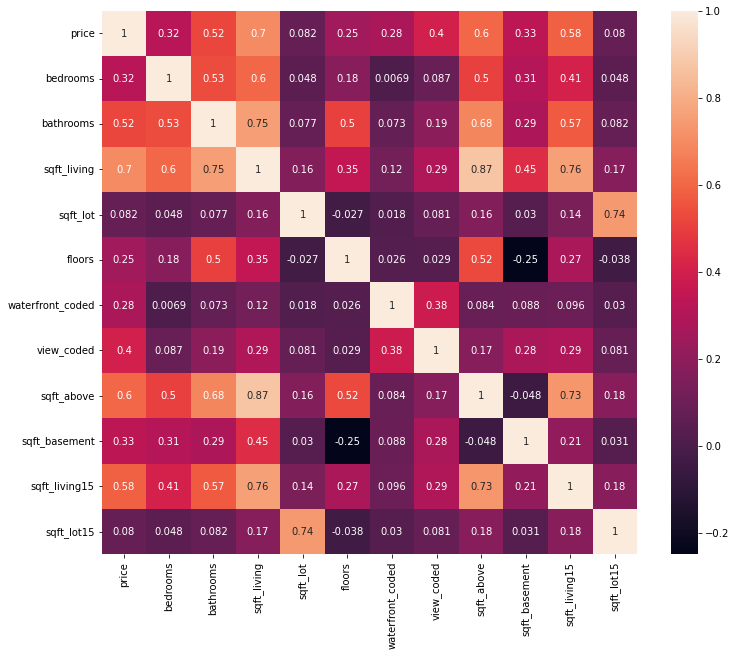

In [40]:
# create a correlation heat map for all the columns relating to house features (sqft, bedrooms, floors, etc)
# checks if there are any features that might cause collinearity issues

cols = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront_coded', 'view_coded', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
corr = df_cities[cols].corr()

fig, ax = plt.subplots(figsize=(12,10)) 
sns.heatmap(corr, annot=True, ax=ax);


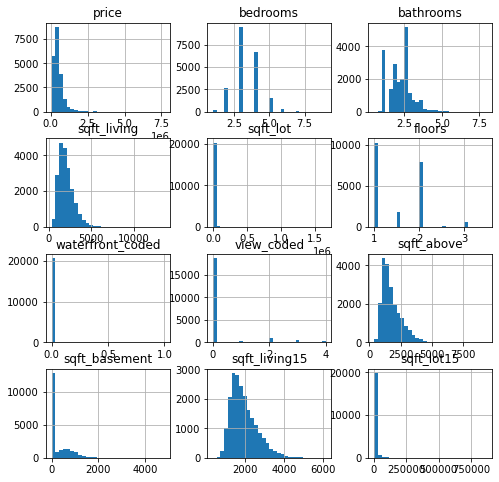

In [41]:
df_cities[cols].hist(figsize = (8,8), bins = 30);

In [42]:
# normalize and numerical columns that dont contain ordinal or categorical numbers
col_norm = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

def norm(series):
    return (series - series.mean())/series.std()
for feat in col_norm:
    df_cities[feat+"_norm"] = norm(df_cities[feat])

In [43]:
# this function creates an ordinary least squares model for price using input columns and data frame 
def ols_model(cols, df):
    predictors = '+'.join(cols)
    formula = 'price' + '~' + predictors
    model = ols(formula=formula, data=df).fit()
    return model

In [44]:
# using an ols model to look at p-values and R^2 values for all of the feature columns
col_pred = ['bedrooms', 'bathrooms', 'sqft_living_norm', 'sqft_lot_norm', 'floors', 'waterfront_coded', 'view_coded', 'sqft_above_norm', 'sqft_basement_norm', 'sqft_living15_norm', 'sqft_lot15_norm']

ols_model(col_pred, df_cities).summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     2734.
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:28:39   Log-Likelihood:            -2.8759e+05
No. Observations:               20809   AIC:                         5.752e+05
Df Residuals:                   20798   BIC:                         5.753e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           6.687e+05    1.1e+04     61.034      0.000    6.47e+05     6.9e+05
bedrooms           -5.254e+04   2417.382    -21.734      0.000   -5.73e+04   -4.78e+04
bathrooms           3507.7634   3715.233      0.944      0.345   -3774.383    1.08e+04
sqft_living_norm    1.211e+05   1801.301     67.232      0.000    1.18e+05    1.25e+05
sqft_lot_norm        226.5408   2506.858      0.090      0.928   -4687.097    5140.178
floors              1.369e+04   4214.015      3.250      0.001    5433.644     2.2e+04
waterfront_coded    6.598e+05   2.31e+04     28.592      0.000    6.15e+05    7.05e+05
view_coded          7.065e+04   2562.700     27.568      0.000    6.56e+04    7.57e+04
sqft_above_norm     1.009e+05   1939.839     51.999      0.000    9.71e+04    1.05e+05
sqft_basement_norm   6.28e+04   1843.612     34.062      0.000    5.92e+04    6.64e+04
sqft_living15_norm  3.626e+04   2706.496     13.397      0.000     3.1e+04    4.16e+04
sqft_lot15_norm    -2.141e+04   2523.883     -8.484      0.000   -2.64e+04   -1.65e+04
==============================================================================
Omnibus:                    13050.962   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           486035.491
Skew:                           2.458   Prob(JB):                         0.00
Kurtosis:                      26.161   Cond. No.                     1.31e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.45e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Multicollinearity Issues
---

There are potential multicollinearity issues with **sqft_above** and **sqft_living**, **sqft_living** and **bathrooms**, **sqft_living15** and **sqft_living**, and **sqft_lot15** and **sqft_lot** - this is due to high correlation values

**Bathrooms** has also proved to not be statistically significant (p > 0.05)

Best option to remove **sqft_above**, **sqft_living15**, **sqft_lot15**, and **bathrooms** columns to avoid any potential modeling issues

**sqft_lot** and **floors** did not have a significant effect on the R^2 value for the ols model, so we have removed these column from the model as well

In [45]:
# finalized list of features to be used for regression
cols_features = ['bedrooms', 'sqft_living_norm', 'waterfront_coded', 'view_coded']

In [46]:
# below is the ols model for the final selection of columns for house features
# chose these columns based on p-value and how each effected R^2 value

ols_model(cols_features, df_cities).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     6643.
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:28:39   Log-Likelihood:            -2.8776e+05
No. Observations:               20809   AIC:                         5.755e+05
Df Residuals:                   20804   BIC:                         5.756e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         6.954e+05   8301.721     83.772      0.000    6.79e+05    7.12e+05
bedrooms         -5.247e+04   2381.399    -22.032      0.000   -5.71e+04   -4.78e+04
sqft_living_norm  2.647e+05   2228.619    118.761      0.000     2.6e+05    2.69e+05
waterfront_coded  6.483e+05   2.32e+04     27.911      0.000    6.03e+05    6.94e+05
view_coded        7.461e+04   2509.194     29.735      0.000    6.97e+04    7.95e+04
==============================================================================
Omnibus:                    12375.239   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           394928.758
Skew:                           2.319   Prob(JB):                         0.00
Kurtosis:                      23.832   Cond. No.                         49.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# drop the unused feature columns from the data frame to continue with out regression modeling
# drop_cols = ['sqft_lot', 'sqft_above', 'sqft_basement', 'bathrooms', 'floors', 'sqft_living', 'sqft_living15', 'sqft_lot15', 'sqft_lot15_norm', \
#             'sqft_living15_norm', 'sqft_lot_norm', 'sqft_above_norm', 'sqft_basement_norm']
drop_cols = ['sqft_lot', 'sqft_above', 'sqft_basement', 'bathrooms', 'floors', 'sqft_living', 'sqft_living15', 'sqft_lot15', 'sqft_lot15_norm', \
            'sqft_living15_norm', 'sqft_lot_norm', 'sqft_above_norm']

df_cities = df_cities.drop(drop_cols, axis=1)


In [48]:
df_cities.columns

Index(['price', 'bedrooms', 'yr_built', 'yr_renovated', 'condition_code',
       'grade_code', 'age', 'renovated', 'age_of_renovations',
       'waterfront_coded', 'view_coded', 'x0_Algona', 'x0_Auburn',
       'x0_Beaux Arts Village', 'x0_Bellevue', 'x0_Black Diamond',
       'x0_Bothell', 'x0_Burien', 'x0_Carnation', 'x0_Clyde Hill',
       'x0_Cottage Lake', 'x0_Covington', 'x0_Des Moines', 'x0_Duvall',
       'x0_Edmonds', 'x0_Enumclaw', 'x0_Fall City', 'x0_Federal Way',
       'x0_Hunts Point', 'x0_Issaquah', 'x0_Kenmore', 'x0_Kent', 'x0_Kirkland',
       'x0_Lake Forest Park', 'x0_Lakeland North', 'x0_Lakeland South',
       'x0_Maple Valley', 'x0_Medina', 'x0_Mercer Island', 'x0_Milton',
       'x0_Newcastle', 'x0_Normandy Park', 'x0_North Bend', 'x0_Pacific',
       'x0_Preston', 'x0_Ravensdale', 'x0_Redmond', 'x0_Renton',
       'x0_Sammamish', 'x0_SeaTac', 'x0_Seattle', 'x0_Shoreline',
       'x0_Skykomish', 'x0_Snoqualmie', 'x0_Tukwila',
       'x0_Union Hill-Novelty Hill', 

In [49]:
# create a train test split model to output the R^2 value and the mean squared error for the house feature columns
X = df_cities[cols_features]
y = df_cities['price']

#create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#create model
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X_train)
model = LinearRegression()
model.fit(X_poly, y_train)

#predict model
predict_train = model.predict(X_poly)
predict_test = model.predict(poly.transform(X_test))
mse = mean_squared_error(y_test, predict_test)

#score model
train_score = model.score(X_poly, y_train)
test_score = model.score(poly.transform(X_test), y_test)

train_score, test_score, mse


print(f'Train Score: {train_score}\nTest Score: {test_score}\nMean Squared Error: {mse}')

Train Score: 0.6034047223154878
Test Score: 0.5558686634236811
Mean Squared Error: 62872371004.31573


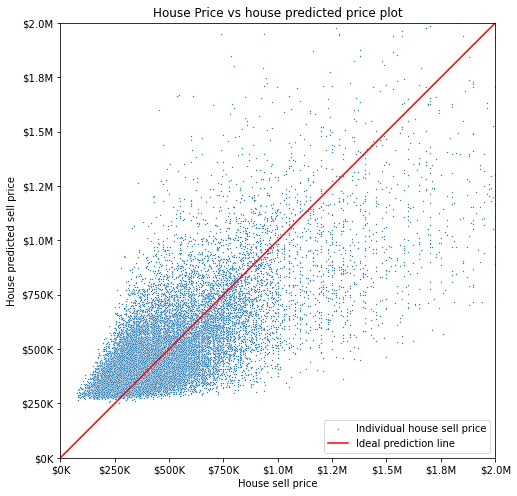

In [50]:
def currency(x, pos):
    """The two args are the value and tick position"""
    if x >= 1e9:
        s = '${:1.1f}B'.format(x*1e-9)
    elif x >= 1e6:
        s = '${:1.1f}M'.format(x*1e-6)
    else:
        s = '${:1.0f}K'.format(x*1e-3)
    return s

x_line = np.linspace(0,2000000)
fig,axs = plt.subplots(figsize = (12,8))
sns.scatterplot(np.concatenate((y_test,y_train)),np.concatenate((predict_test, predict_train)), marker = "." , s = 8,alpha = 1, label = "Individual house sell price")
axs.plot(x_line, x_line, color ="red", label = "Ideal prediction line")
axs.set_xlim(0,2000000) ; axs.set_ylim(0,2000000)
axs.yaxis.set_major_formatter(currency)
axs.xaxis.set_major_formatter(currency)
axs.set_aspect("equal")
axs.set_title("House Price vs house predicted price plot")
axs.set_xlabel("House sell price")
axs.set_ylabel("House predicted sell price")
axs.legend();
plt.savefig("./images/PricevsPredict_scatter_v1.png")

## Analysing Regression With Property Condition Data

Looking at the data corresponding to the condition of the property we subset the following columns:
'condition_code', 'grade_code', 'age', 'age_of_renovations', and 'renovated'

We then look at correlations between these variables:

In [51]:
# First I'll crate some basic variables that will be use through the analysis and modeling
df_condition = df_cities[['price','condition_code','grade_code','age','age_of_renovations','renovated']]
X_condition = df_condition[['condition_code','grade_code','age','age_of_renovations','renovated']]
y_condition = df_condition.price

In [52]:
# Now lest look at the feature correlations
X_condition.corr()

,condition_code,grade_code,age,age_of_renovations,renovated
condition_code,1.000000,-0.143404,0.358635,-0.005028,-0.057591
grade_code,-0.143404,1.000000,-0.445096,-0.018371,0.018430
age,0.358635,-0.445096,1.000000,0.171060,0.201222
age_of_renovations,-0.005028,-0.018371,0.171060,1.000000,0.732604
renovated,-0.057591,0.018430,0.201222,0.732604,1.000000


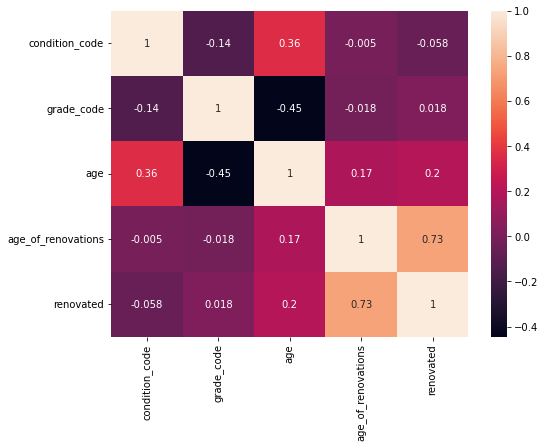

In [53]:
# We can view this as a heat map to give a better view
plt.figure(figsize=(8,6))
sns.heatmap(X_condition.corr(), annot=True)
plt.show()

We can see that 'age_of_renovations' is closely correlated with 'renovated' and may cause multicolinearity issues. Indeed they are related to the same characteristsic and tell the same tale. We can eliminate one of these from our analysis.

If a property is showing a value > 1 in 'age_of_renovations' then we know it has been renovated which tells us the same as the 'renovated' column... so we will drop 'renovated'

In [54]:
formula_cond = 'price ~ condition_code + grade_code + age + age_of_renovations'

condition_model = ols(formula=formula_cond, data=df_condition).fit()
condition_model_summ = condition_model.summary()

print(condition_model_summ)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     5727.
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:28:41   Log-Likelihood:            -2.8859e+05
No. Observations:               20809   AIC:                         5.772e+05
Df Residuals:                   20804   BIC:                         5.772e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.672e+06    1.7

Lets take a look at some regressions and see what will give us the strongest model based on the condition variables

Using all of our features, we get a strong score on both a training data set and also the test set

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_condition, 
                                                    y_condition,
                                                    test_size=None,
                                                    random_state=42
                                                   )

lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)
lr.score(X_test, y_test)

print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.5271743330567502
0.5234592881859601


We don't need all of these features though so lets iterate through some linear regressions with different feature combinations and see what will give us the simplest, but highest scoring model

In [56]:
# dropping the 'renovated' feature that was giving us multicolinearity issues

X_condition_1 = df_condition[['condition_code','grade_code','age','age_of_renovations']]
X_train, X_test, y_train, y_test = train_test_split(X_condition_1, 
                                                    y_condition,
                                                    test_size=None,
                                                    random_state=42
                                                   )

lr = LinearRegression()
lr.fit(X_train, y_train)

print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.5256379052856822
0.5195123287711394


Conditon and Grade tell a similar story about a property. Looking at he data we see Grade is a lot more in depth and provides more bins, so it is potentially more powerful. Lets drop Condition.

In [57]:
# dropping the 'condition_code' feature from the model

X_condition_2 = df_condition[['grade_code','age','age_of_renovations']]
X_train, X_test, y_train, y_test = train_test_split(X_condition_2, 
                                                    y_condition,
                                                    test_size=None,
                                                    random_state=42
                                                   )

lr = LinearRegression()
lr.fit(X_train, y_train)

print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.5230926151621096
0.5178558889762599


That barely chaged our model score, and indeed when we look at just Condition it doesn't score well.

In [58]:
X_condition_3 = df_condition[['condition_code']]
X_train, X_test, y_train, y_test = train_test_split(X_condition_3, 
                                                    y_condition,
                                                    test_size=None,
                                                    random_state=42
                                                   )

lr = LinearRegression()
lr.fit(X_train, y_train)

print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.0018602320334812905
0.0007077178390301198


However, looking at just Grade we can see that it scores well and is indeed our strongest feature.

In [59]:
X_condition_4 = df_condition[['grade_code']]
X_train, X_test, y_train, y_test = train_test_split(X_condition_4, 
                                                    y_condition,
                                                    test_size=None,
                                                    random_state=42
                                                   )

lr = LinearRegression()
lr.fit(X_train, y_train)

print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.4442054397187263
0.4401029411472318


Including the 'age_of_renovations' feature does not add much to the model, so we will drop that as well

In [60]:
X_condition_5 = df_condition[['grade_code','age_of_renovations']]
X_train, X_test, y_train, y_test = train_test_split(X_condition_5, 
                                                    y_condition,
                                                    test_size=None,
                                                    random_state=42
                                                   )

lr = LinearRegression()
lr.fit(X_train, y_train)

print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.44956910715008025
0.44593878021761835


*Interestingly, Age does not score well by itself. However, when coupled with the Grade feature it gives a large improvement to the overall score.

This combination of features gives us the highest score, with the least features.

In [61]:
X_condition_6 = df_condition[['age']]
X_train, X_test, y_train, y_test = train_test_split(X_condition_6, 
                                                    y_condition,
                                                    test_size=None,
                                                    random_state=42
                                                   )

lr = LinearRegression()
lr.fit(X_train, y_train)

print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.0018728403251327963
0.002791746083447011


In [62]:
X_condition_7 = df_condition[['grade_code','age']]
X_train, X_test, y_train, y_test = train_test_split(X_condition_7, 
                                                    y_condition,
                                                    test_size=None,
                                                    random_state=42
                                                   )

lr = LinearRegression()
lr.fit(X_train, y_train)

print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.5225494083671667
0.5172432011689839


Indeed, these are the two columns we will include on the overall "Linear Regression" model

Lets now look at some Polynomial regressions on the "condition" data and see if we can improve on our model

In [63]:
X_conditions = [X_condition, X_condition_1, X_condition_2, X_condition_3, X_condition_4, X_condition_5, X_condition_6, X_condition_7]

In [64]:
# A function thet interates through our combinations to determine the the best number of Polynomial Features
# It returns an array of train and test scores for each combination

def poly_scores_array (X_lst, y):
    poly_scores = []
    for X in X_lst:
        train_scores = []
        test_scores = []
        for i in range(1,7):
            poly = PolynomialFeatures(i)
            X_poly = pd.DataFrame(poly.fit_transform(X))
            X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=None, random_state=42)
            model = LinearRegression()
            model.fit(X_train, y_train)
            train_scores.append(model.score(X_train, y_train))
            test_scores.append(model.score(X_test, y_test))
            scores = (train_scores, test_scores)
            poly_scores.append(scores)
    return poly_scores

poly_scores_array(X_conditions, y_condition)

[([0.5271743330567502,
   0.6036925892418813,
   0.6218326799673232,
   0.640284989037988,
   0.652602098754411,
   0.6618996315214396],
  [0.5234592881859601,
   0.5867559208851889,
   0.5889960671079019,
   0.5843597773779026,
   0.3302388854493533,
   -2593.586600336727]),
 ([0.5271743330567502,
   0.6036925892418813,
   0.6218326799673232,
   0.640284989037988,
   0.652602098754411,
   0.6618996315214396],
  [0.5234592881859601,
   0.5867559208851889,
   0.5889960671079019,
   0.5843597773779026,
   0.3302388854493533,
   -2593.586600336727]),
 ([0.5271743330567502,
   0.6036925892418813,
   0.6218326799673232,
   0.640284989037988,
   0.652602098754411,
   0.6618996315214396],
  [0.5234592881859601,
   0.5867559208851889,
   0.5889960671079019,
   0.5843597773779026,
   0.3302388854493533,
   -2593.586600336727]),
 ([0.5271743330567502,
   0.6036925892418813,
   0.6218326799673232,
   0.640284989037988,
   0.652602098754411,
   0.6618996315214396],
  [0.5234592881859601,
   0.5867

Just eyeballing the array we conistently get our highest scores up to 4 polynomial features and then our test scores drop significantly.

In [65]:
# Having determined the best number of polynomial features is 4 for the property condition data
# Create a function to iterate through our feature combinations to determine the best model

def best_poly_model (X_lst, y):
    poly_model_scores = []
    for X in X_lst:
        poly_2 = PolynomialFeatures(4)
        X_poly = pd.DataFrame(poly_2.fit_transform(X))
        X_train, X_test, y_train, y_test = train_test_split(X_poly, y,
                                                    test_size=None,
                                                    random_state=42)
        lr_poly = LinearRegression()
        lr_poly.fit(X_train, y_train)
        train_score = lr_poly.score(X_train, y_train)
        test_score = lr_poly.score(X_test, y_test)
        score = (train_score, test_score)
        poly_model_scores.append(score)
    return poly_model_scores

best_poly_model (X_conditions, y_condition)

[(0.640284989037988, 0.5843597773779026),
 (0.6350012560835252, 0.5981433739301623),
 (0.6202374972882756, 0.5959431416138805),
 (0.007248591776713775, 0.004823795604980252),
 (0.5184962728936298, 0.5149777999927309),
 (0.5376934309627892, 0.5274238243091314),
 (0.027081682172057087, 0.029939275074566618),
 (0.610455700161963, 0.5982095287226269)]

The array above corresponds to our feature combinations. In our linear regression analysis we determined that X_condition_7 gave us our best model and we can see above that the same combination gives us excellent results and even scores the best on the test data overall.

Lets see this isolated below

In [66]:
poly_7 = PolynomialFeatures(4)
X_poly_7 = pd.DataFrame(poly_7.fit_transform(X_condition_7))
X_train, X_test, y_train, y_test = train_test_split(X_poly_7, y_condition,
                                                    test_size=None,
                                                    random_state=42)
lr_poly_7 = LinearRegression()
lr_poly_7.fit(X_train, y_train)

print(lr_poly_7.score(X_train, y_train))
print(lr_poly_7.score(X_test, y_test))

0.610455700161963
0.5982095287226269


After performing both linear and polynomial regression analysis on the Property Condition data, we have determined that _Grade (as coded in 'gradecode') and Age are the best variables to use in our model

In [67]:
cols_to_drop = ['yr_built', 'yr_renovated', 'renovated', 'age_of_renovations']
df_cities = df_cities.drop(cols_to_drop, axis=1)

In [68]:
df_cities.columns

Index(['price', 'bedrooms', 'condition_code', 'grade_code', 'age',
       'waterfront_coded', 'view_coded', 'x0_Algona', 'x0_Auburn',
       'x0_Beaux Arts Village', 'x0_Bellevue', 'x0_Black Diamond',
       'x0_Bothell', 'x0_Burien', 'x0_Carnation', 'x0_Clyde Hill',
       'x0_Cottage Lake', 'x0_Covington', 'x0_Des Moines', 'x0_Duvall',
       'x0_Edmonds', 'x0_Enumclaw', 'x0_Fall City', 'x0_Federal Way',
       'x0_Hunts Point', 'x0_Issaquah', 'x0_Kenmore', 'x0_Kent', 'x0_Kirkland',
       'x0_Lake Forest Park', 'x0_Lakeland North', 'x0_Lakeland South',
       'x0_Maple Valley', 'x0_Medina', 'x0_Mercer Island', 'x0_Milton',
       'x0_Newcastle', 'x0_Normandy Park', 'x0_North Bend', 'x0_Pacific',
       'x0_Preston', 'x0_Ravensdale', 'x0_Redmond', 'x0_Renton',
       'x0_Sammamish', 'x0_SeaTac', 'x0_Seattle', 'x0_Shoreline',
       'x0_Skykomish', 'x0_Snoqualmie', 'x0_Tukwila',
       'x0_Union Hill-Novelty Hill', 'x0_Vashon', 'x0_Woodinville',
       'x0_Yarrow Point', 'sqft_living_

### Regression Model for Property Feature Columns and Property Condition Columns

Now that we have narrowed down our property feature columns and property condition columns we can create a new regression model

In [69]:
cols_feat_cond = ['bedrooms', 'sqft_living_norm', 'waterfront_coded', 'view_coded', 'grade_code', 'age']

In [70]:
# create a train test split model to output the R^2 value and the mean squared error 
# for the property feature columns combined with property condition columns
X = df_cities[cols_feat_cond]
y = df_cities['price']

#create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#create model - polynomial 2 is the best fit for this data (highest scores and lowest mean squared error)
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X_train)
model = LinearRegression()
model.fit(X_poly, y_train)

#predict model
predict_train = model.predict(X_poly)
predict_test = model.predict(poly.transform(X_test))
mse = mean_squared_error(y_test, predict_test)

#score model
train_score = model.score(X_poly, y_train)
test_score = model.score(poly.transform(X_test), y_test)

train_score, test_score, mse


print(f'Train Score: {train_score}\nTest Score: {test_score}\nMean Squared Error: {mse}')
type(predict_train)

Train Score: 0.7104836374409886
Test Score: 0.6922199449836401
Mean Squared Error: 43570133906.532074


numpy.ndarray

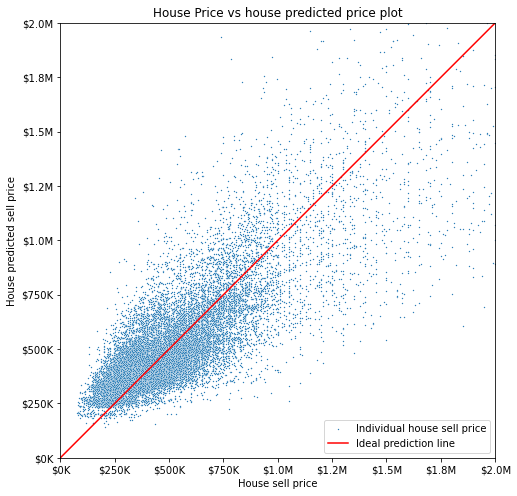

In [71]:
x_line = np.linspace(0,2000000)
fig,axs = plt.subplots(figsize = (12,8))
sns.scatterplot(np.concatenate((y_test,y_train)),np.concatenate((predict_test, predict_train)), marker = "." , s = 8,alpha = 1, label = "Individual house sell price")
axs.plot(x_line, x_line, color ="red", label = "Ideal prediction line")
axs.set_xlim(0,2000000) ; axs.set_ylim(0,2000000)
axs.yaxis.set_major_formatter(currency)
axs.xaxis.set_major_formatter(currency)
axs.set_aspect("equal")
axs.set_title("House Price vs house predicted price plot")
axs.set_xlabel("House sell price")
axs.set_ylabel("House predicted sell price")
axs.legend();
plt.savefig("./images/PricevsPredict_scatterv2.png")

As we can see the R^2 scores for our new model is better than both the Property Features Model and the Property Condition Model. This shows us that are new data better fits our regression line!

Now it's time to add in our location data for our final regression model!

# Regression Results

Below we have created a linear regression calculator which will output our R^2 value (model accuracy) as well as the mean squared error for our finalized dataset. It will also print out a random sample of our predictive model

In [120]:
# function for modeling linear regression 


def linear_reg_calculator(Data, n = 1, explore = False, sample_df = []):
    #model preparation
    Data = Data.reset_index().drop("index", axis = 1)
    poly = PolynomialFeatures(n)
    linreg = LinearRegression()
    scoring_model = ["r2", "neg_mean_squared_error"]
    kf = KFold(n_splits=5)
    y = Data["price"]
    X = Data.drop("price", axis = 1)    
    # execute code that will generate warnings
    # Fit and transform X for polynomial function
    if n > 1:
        X_new = X.drop(df_cities_columns, axis = 1)    # Drop geo categorical data
        X_poly= poly.fit_transform(X_new)                                        # Poly transformation on numerical data
        X = pd.concat([pd.DataFrame(X_poly), Data[df_cities_columns]], axis = 1) # Making new dataframe
        
    
    else:
        pass
    
    # Modelling
    reg_poly = cross_validate(linreg, X, y, scoring= scoring_model, cv = kf, return_estimator = True)
    mean = np.mean(reg_poly["test_r2"])
    stand = np.std(reg_poly["test_r2"])
    model = reg_poly["estimator"][0]
    mean_mean_sq_error = -np.mean(reg_poly["test_neg_mean_squared_error"])
    
    #Explore
    if explore == True:
        sample_df = sample_df.reset_index().drop("index", axis = 1)
        X = sample_df.drop("price",axis=1)
        if n > 1:
            X_new = X.drop(df_cities_columns, axis = 1)    # Drop geo categorical data
            X_poly= poly.fit_transform(X_new)                                        # Poly transformation on numerical data
            X = pd.concat([pd.DataFrame(X_poly), sample_df[df_cities_columns]], axis = 1) # Making new dataframe
        prices_sample = model.predict(X)
        mean_sample = round(np.mean(prices_sample), 0)
        median_sample = round(np.median(prices_sample), 0)
        std_sample = round(np.std(prices_sample), 0)
        
        return prices_sample, mean_sample, median_sample, std_sample
        
    
    
    # Random house experiment
    difference_list=[]
    random_sample = np.random.randint(0, len(y))                         # Choose the random house from our prediction
    y_hat = cross_val_predict(linreg, X, y, cv = kf)                     # Make predictions based on our model 
    price = round(y[random_sample],0)                                    # sample house price
    predicted_price = round(y_hat[random_sample], 0)                     # sample house predicted price
    difference = round(100*(y_hat[random_sample]/y[random_sample]-1),2)  # difference between prices
    
    # Random 20 houses prediction
    for i in list(range(20)):
        random_sample = np.random.randint(0, len(y))
        difference_list.append(round(100*(y_hat[random_sample]/y[random_sample]-1),2))
    difference_mean = round(np.mean(difference_list),2)    
    difference_std = round(np.std(difference_list),2)    
    
    #Outputs
    print(f"Model accuracy based on R2 score {round(mean*100,1)}% with 95% conf interval +-{round(2*stand*100,1)}%")
    print(f"Mean Squared Error {round(mean_mean_sq_error, 0)}")
    print(f"Random house price {price}, predicted price {predicted_price}, difference {difference} %")
    print(f"Sample(20 houses) prediction price difference {difference_mean} %")
    return mean_mean_sq_error, mean, y_hat, y
    
#Work example
(MSE, mean_ac, y_hat_regr, y_reg) = linear_reg_calculator(df_cities, 2, [])

Model accuracy based on R2 score 80.7% with 95% conf interval +-3.9%
Mean Squared Error 26151639698.0
Random house price 615000.0, predicted price 645530.0, difference 4.96 %
Sample(20 houses) prediction price difference -4.86 %


In [103]:
(MSE, mean_ac, y_hat_regr, y_reg) = linear_reg_calculator(df_cities, 2)

Model accuracy based on R2 score 80.7% with 95% conf interval +-3.9%
Mean Squared Error 26151639698.0
Random house price 531000.0, predicted price 513511.0, difference -3.29 %
Sample(20 houses) prediction price difference 10.15 %


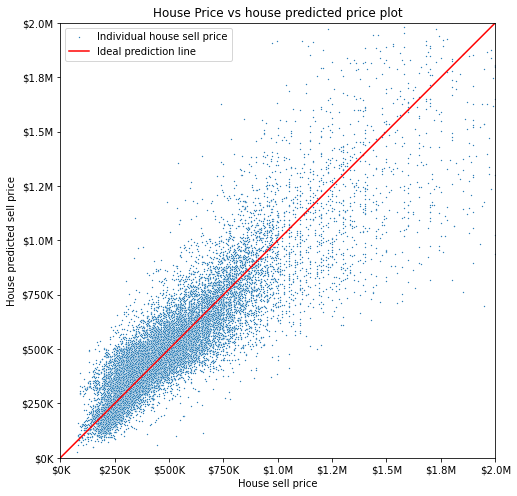

In [75]:
# Linear regression performance plot.

x_line = np.linspace(0,2000000)
fig,axs = plt.subplots(figsize = (12,8))
sns.scatterplot(y_reg,y_hat_regr , marker = "." , s = 8,alpha = 1, label = "Individual house sell price")
axs.plot(x_line, x_line, color ="red", label = "Ideal prediction line")
axs.set_xlim(0,2000000) ; axs.set_ylim(0,2000000)
axs.yaxis.set_major_formatter(currency)
axs.xaxis.set_major_formatter(currency)
axs.set_aspect("equal")
axs.set_title("House Price vs house predicted price plot")
axs.set_xlabel("House sell price")
axs.set_ylabel("House predicted sell price")
axs.legend();
plt.savefig("./images/PricevsPredict_scatterv3.png")

In [122]:
# Sample of 100 houses
sample = df_cities.sample(n=100)
# predict prices for them
(prices_array, mean_sample, median_sample, std_sample) = linear_reg_calculator(df_cities, 2, True, sample)

In [156]:
# Influence of city to median price im prediction model, sample 100 absolutely same houses but in different cities.
sample = df_cities.sample(n=100)
city_names = [city[3:] for city in df_cities_columns]
median_city_list=[]
for city in df_cities_columns:
    sample[df_cities_columns] = 0
    sample[city] = 1
    (prices_array, mean_sample, median_sample, std_sample) = linear_reg_calculator(df_cities, 2, True, sample)
    median_city_list.append(median_sample)
    


In [157]:
# list of median house prices in different cities
median_city_sell = list(zip(median_city_list, city_names))


In [160]:
# Find most expensive cities
Most_expensive_cities = sorted(median_city_sell, reverse = True)

In [171]:
Most_expensive_cities

[(1469393.0, 'Medina'),
 (1292362.0, 'Yarrow Point'),
 (1276025.0, 'Clyde Hill'),
 (1144120.0, 'Hunts Point'),
 (886081.0, 'Beaux Arts Village'),
 (727012.0, 'Mercer Island'),
 (595347.0, 'Bellevue'),
 (539972.0, 'Kirkland'),
 (514616.0, 'Redmond'),
 (501531.0, 'Seattle'),
 (468831.0, 'Union Hill-Novelty Hill'),
 (452020.0, 'Sammamish'),
 (441557.0, 'Woodinville'),
 (435737.0, 'Issaquah'),
 (416761.0, 'Fall City'),
 (414184.0, 'Newcastle'),
 (406870.0, 'Lake Forest Park'),
 (406591.0, 'Edmonds'),
 (406558.0, 'Shoreline'),
 (401310.0, 'Bothell'),
 (398090.0, 'Kenmore'),
 (395075.0, 'Preston'),
 (393238.0, 'Cottage Lake'),
 (388118.0, 'Vashon'),
 (375407.0, 'North Bend'),
 (356912.0, 'Carnation'),
 (356906.0, 'Snoqualmie'),
 (338731.0, 'Duvall'),
 (331263.0, 'Burien'),
 (323553.0, 'Renton'),
 (319738.0, 'Black Diamond'),
 (316319.0, 'Normandy Park'),
 (300886.0, 'Ravensdale'),
 (299460.0, 'SeaTac'),
 (294783.0, 'Tukwila'),
 (287177.0, 'Maple Valley'),
 (286220.0, 'Lakeland North'),
 (282

# Conclusion